## GlucoTrack Project

Objective: to work with a real-world CDC dataset and build a complete pipeline from data preprocessing to deployment using tools like PyTorch/TensorFlow, SHAP, and MLflow to glean insight for Diabetes risk factors.

Source: CDC Diabetes Health Indicators
- Outcome variable: Individuals are classified as diabetic (1) or non-diabetic (0)
- Features: Health, lifestyle, and demographic indicators. 
- All responses were obtained from phone surveys conducted as part of the CDC Behavioral Risk Factor Surveillance System (BRFSS). 
- Few questions represent objective lab measurements (cholesterol, high blood pressure); most are subjective measures of self-assessed health and lifestyle factors. 

In [1]:
# Core Libraries
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Machine Learning
import sklearn
import xgboost as xgb
import lightgbm as lgb

# Experiment Tracking
import mlflow

# Deployment
import streamlit

# Utilities
#python-dotenv

### Week 1: Exploratory Data Analysis (EDA)
- Pay special attention to class imbalance, skewed distributions, and multicollinearity
- Begin identifying features suited for embeddings

In [32]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
cdc_diabetes_health_indicators = fetch_ucirepo(id=891) 
  
# data (as pandas dataframes) 
#21
X = cdc_diabetes_health_indicators.data.features 
# 3
y = cdc_diabetes_health_indicators.data.targets 
  
# metadata 
print(cdc_diabetes_health_indicators.metadata) 
  
# variable information 
print(cdc_diabetes_health_indicators.variables) 


{'uci_id': 891, 'name': 'CDC Diabetes Health Indicators', 'repository_url': 'https://archive.ics.uci.edu/dataset/891/cdc+diabetes+health+indicators', 'data_url': 'https://archive.ics.uci.edu/static/public/891/data.csv', 'abstract': 'The Diabetes Health Indicators Dataset contains healthcare statistics and lifestyle survey information about people in general along with their diagnosis of diabetes. The 35 features consist of some demographics, lab test results, and answers to survey questions for each patient. The target variable for classification is whether a patient has diabetes, is pre-diabetic, or healthy. ', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Tabular', 'Multivariate'], 'num_instances': 253680, 'num_features': 21, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Sex', 'Age', 'Education Level', 'Income'], 'target_col': ['Diabetes_binary'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_

**Here, we take a look at the full descriptions of the dataset features to understand binary and ordinal features.**

In [ ]:
full_descriptions = cdc_diabetes_health_indicators.variables.description   
for i, desc in enumerate(full_descriptions):
    print(f"{i}: {desc}\n")

0: Patient ID

1: 0 = no diabetes 1 = prediabetes or diabetes

2: 0 = no high BP 1 = high BP

3: 0 = no high cholesterol 1 = high cholesterol

4: 0 = no cholesterol check in 5 years 1 = yes cholesterol check in 5 years

5: Body Mass Index

6: Have you smoked at least 100 cigarettes in your entire life? [Note: 5 packs = 100 cigarettes] 0 = no 1 = yes

7: (Ever told) you had a stroke. 0 = no 1 = yes

8: coronary heart disease (CHD) or myocardial infarction (MI) 0 = no 1 = yes

9: physical activity in past 30 days - not including job 0 = no 1 = yes

10: Consume Fruit 1 or more times per day 0 = no 1 = yes

11: Consume Vegetables 1 or more times per day 0 = no 1 = yes

12: Heavy drinkers (adult men having more than 14 drinks per week and adult women having more than 7 drinks per week) 0 = no 1 = yes

13: Have any kind of health care coverage, including health insurance, prepaid plans such as HMO, etc. 0 = no 1 = yes

14: Was there a time in the past 12 months when you needed to see a docto

In [4]:
X.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,1,1,1,40,1,0,0,0,0,1,...,1,0,5,18,15,1,0,9,4,3
1,0,0,0,25,1,0,0,1,0,0,...,0,1,3,0,0,0,0,7,6,1
2,1,1,1,28,0,0,0,0,1,0,...,1,1,5,30,30,1,0,9,4,8
3,1,0,1,27,0,0,0,1,1,1,...,1,0,2,0,0,0,0,11,3,6
4,1,1,1,24,0,0,0,1,1,1,...,1,0,2,3,0,0,0,11,5,4


**The metadata summary indicated there are no missing values, but we will doublecheck here**

In [ ]:
missing_values = X[X.isna().any(axis=1)]
missing_values

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income


**Here, we check for constant features**

In [ ]:
constant_features = [col for col in X.columns if X[col].nunique() == 1]
constant_features

[]

**Check for duplicate rows**

In [ ]:
duplicate_rows = X[X.duplicated()]
print(f"Number of duplicate rows: {duplicate_rows.shape[0]}")


Number of duplicate rows: 25772


**Create a dataframe with the dependent variable column for plotting and analysis**

In [ ]:

df = X.copy()
df["Diabetes_binary"] = y
df.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,Diabetes_binary
0,1,1,1,40,1,0,0,0,0,1,...,0,5,18,15,1,0,9,4,3,0
1,0,0,0,25,1,0,0,1,0,0,...,1,3,0,0,0,0,7,6,1,0
2,1,1,1,28,0,0,0,0,1,0,...,1,5,30,30,1,0,9,4,8,0
3,1,0,1,27,0,0,0,1,1,1,...,0,2,0,0,0,0,11,3,6,0
4,1,1,1,24,0,0,0,1,1,1,...,0,2,3,0,0,0,11,5,4,0


In [34]:
df.shape
print("The dataset has {} rows and {} columns.".format(df.shape[0], df.shape[1]))

The dataset has 253680 rows and 22 columns.


**Check the distribution of subjects with diabetes vs those without**

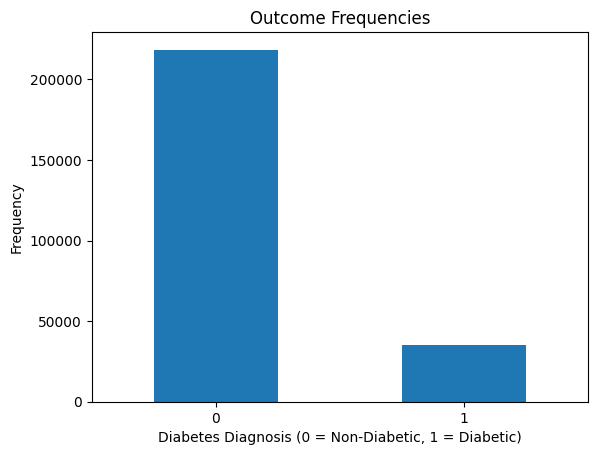

In [44]:
df['Diabetes_binary'].value_counts().plot(kind='bar')
plt.title('Outcome Frequencies')
plt.xticks(rotation=0)
plt.xlabel('Diabetes Diagnosis (0 = Non-Diabetic, 1 = Diabetic)')  
plt.ylabel('Frequency')  
plt.show()

In [11]:
print(len(y[y["Diabetes_binary"] == 1]), "patients marked diabetic/prediabetic and", len(y[y["Diabetes_binary"] == 0]), "patients marked no diabetes")
print(len(y[y["Diabetes_binary"] == 0])/ len(y[y["Diabetes_binary"] == 1]), "controls for each patient marked diabetic/prediabetic")

35346 patients marked diabetic/prediabetic and 218334 patients marked no diabetes
6.177049736886777 controls for each patient marked diabetic/prediabetic



**This dataset contains a class imbalance, 1:6 (14.3% minority), which means that accuracy alone is not a reliable metric, as a model could predict the majority class (healthy controls) most of the time and still appear accurate.
Alternatives:**

- Use metrics like precision, recall, F1-score, and AUC to better assess performance on the minority (diabetes) class.
- Consider stratified sampling for train/test splits.
- Use class weighting in models (e.g., class_weight='balanced' in scikit-learn).
- Try resampling techniques (oversampling the minority class or undersampling the majority).
- Consider using algorithms that handle imbalance well (e.g., tree-based models with built-in class weighting).

- Consider resampling by downsampling controls or upsample cases (e.e. SMOTE)
- May also use class weighting (class_weight='balanced' in scikit-learn)

**Create a dataframe without the binary variables to look at distributions**

In [ ]:
df_numeric = df.select_dtypes(include=['number']).copy()
df_numeric = df_numeric.loc[:, df_numeric.nunique() > 2]
df_numeric.head()

,BMI,GenHlth,MentHlth,PhysHlth,Age,Education,Income
0,40,5,18,15,9,4,3
1,25,3,0,0,7,6,1
2,28,5,30,30,9,4,8
3,27,2,0,0,11,3,6
4,24,2,3,0,11,5,4


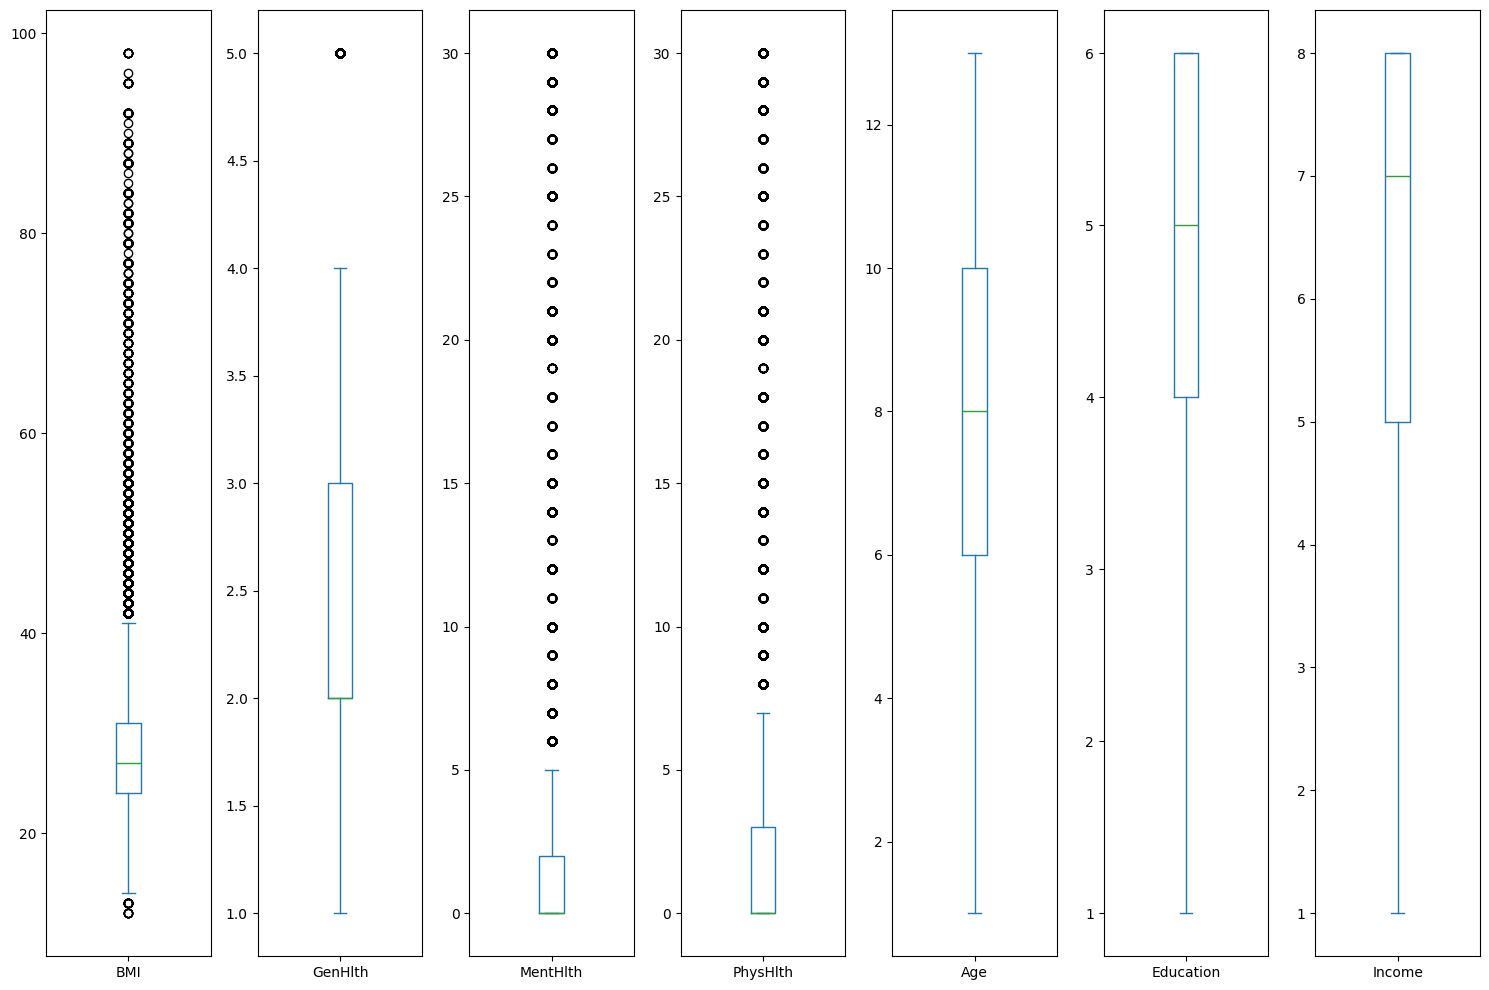

In [13]:
df_numeric.plot(kind='box', subplots=True, figsize=(15,10), sharex=False, sharey=False)
plt.tight_layout()
plt.show()

**BMI shows outlier values that exceed the value for Class III obesity (BMI >= 40).  This was surprising to me, especially at the top ranges which indicate subjects whose weight is greater than 500 pounds.  I found this statistic on google:**

**Approximately 9.2% of adults in the U.S. have a BMI of 40 or higher, which is considered severe obesity. This translates to roughly 23 million adults based on the U.S. population of 251.4 million adults aged 20 and older, according to the U.S. Census Bureau.**


**How many subjects have BMI > 40?**

In [47]:
bmi_outliers = df_numeric[df_numeric['BMI'] > 40]     
print(f"Number of BMI subjects with BMI > 40 is: {bmi_outliers.shape[0]}")
  

Number of BMI subjects with BMI > 40 is: 11479


**Some of these observations are duplicates however:**

In [ ]:
bmi_outliers_duplicates = bmi_outliers[bmi_outliers.duplicated()]   
print(f"Number of BMI outliers that are duplicates: {bmi_outliers_duplicates.shape[0]}")


Number of BMI outliers that are duplicates: 961


**Look at the orginal dataframe without the duplicate rows, then count the number of observations with BMI > 40, and print the percentage of the total subject observations.  We see here that it is less than the Census Bureau's population prevalance of 9.2%.**

**Does this indicate any issues regarding representation of this dataset to the general US population?**

In [ ]:
df_no_duplicates = df.drop_duplicates() 
bmi_outliers_no_duplicates = df_no_duplicates[df_no_duplicates['BMI'] > 40]
print(f"Percentage of BMI outliers (BMI > 40) in the dataset: {(bmi_outliers_no_duplicates.shape[0] / df_no_duplicates.shape[0]) * 100:.2f}%")  

                                                               

Percentage of BMI outliers (BMI > 40) in the dataset: 5.00%


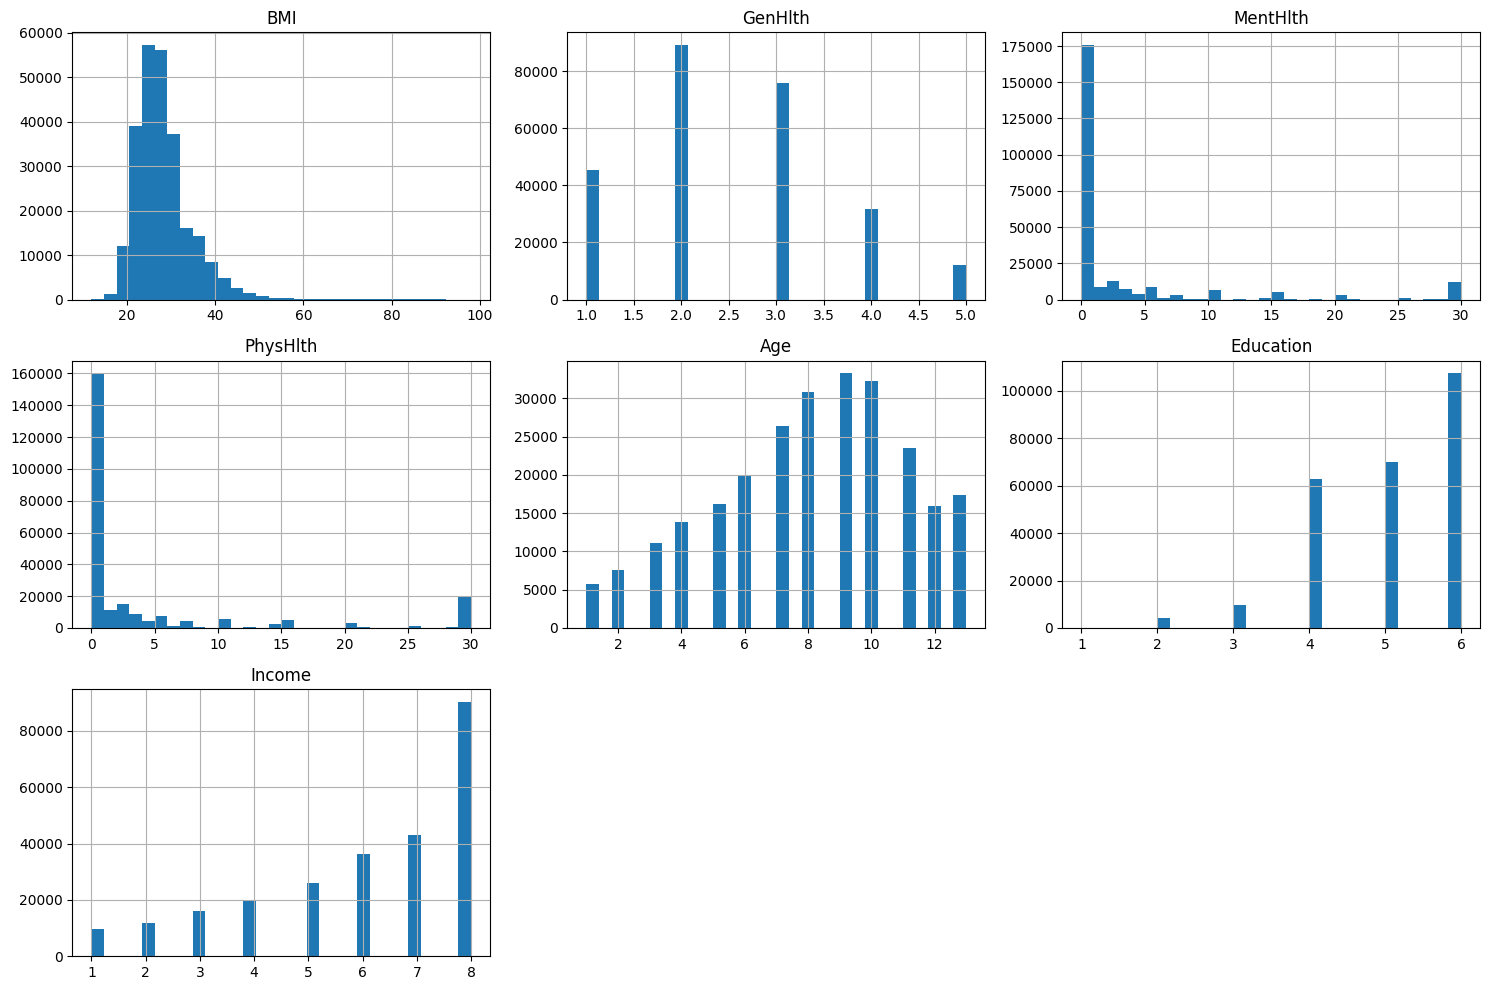

In [17]:
df_numeric.hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()

**BMI, mental health and physical health contain a high number of outliers. General health contains one marked outlier, but this is an ordinal scale of 1-5, so we could look at those observations to better understand the subpopulation that responded this way to understand if this is true subpopulation or an anomaly/error.**

**Age, education and income are right-skewed.**

**Possible transformations to consider include Box-Cox or Yeo-Johnson cor use with the ordinal features and Robust Scalar from sklearn can be used for the features with outliers.**

**Here, we compare the means of the numeric features to the dependent variable by looking at the distributions of the features by diabetes classification**

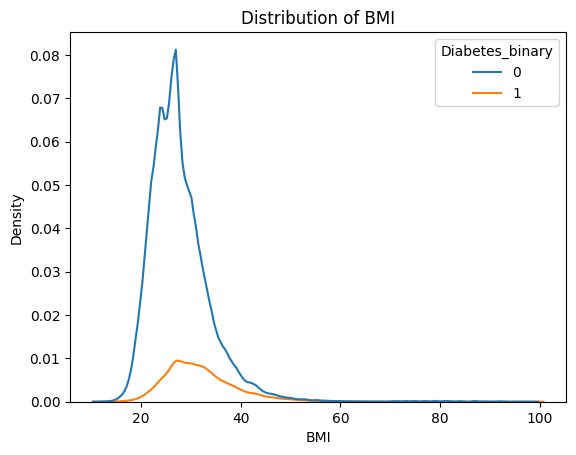

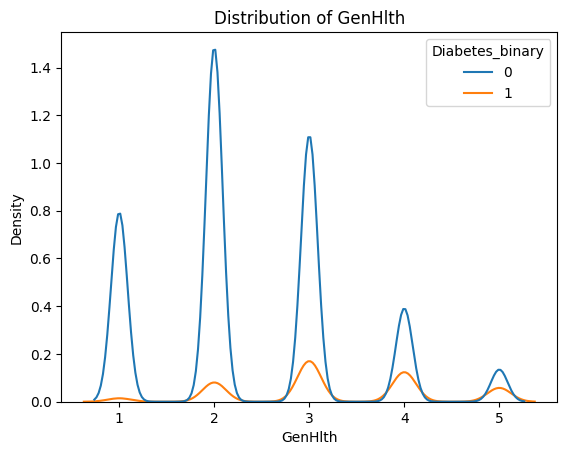

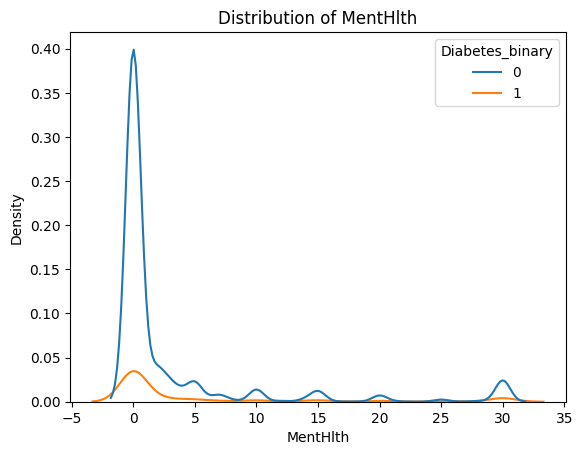

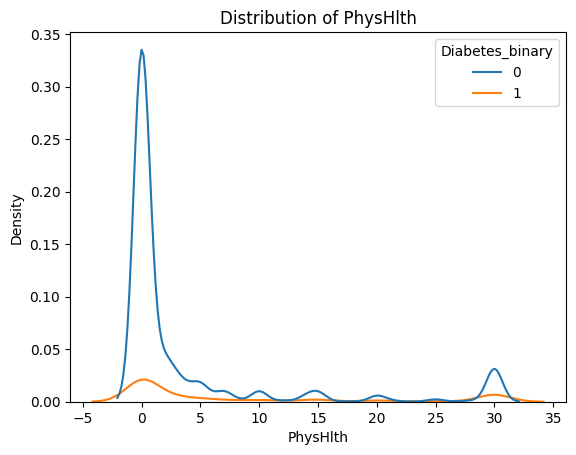

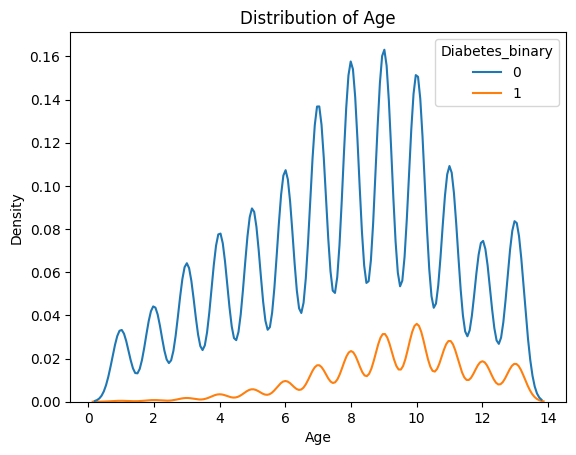

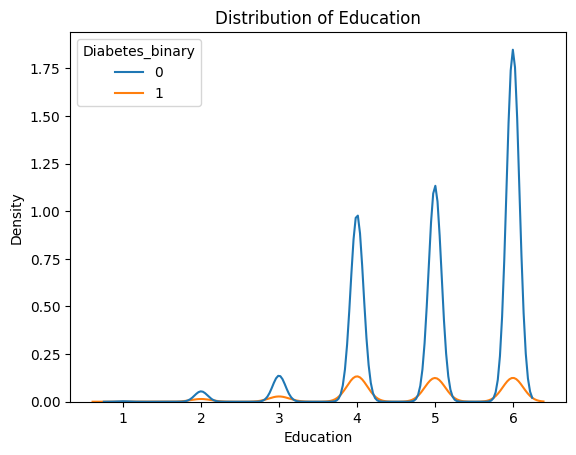

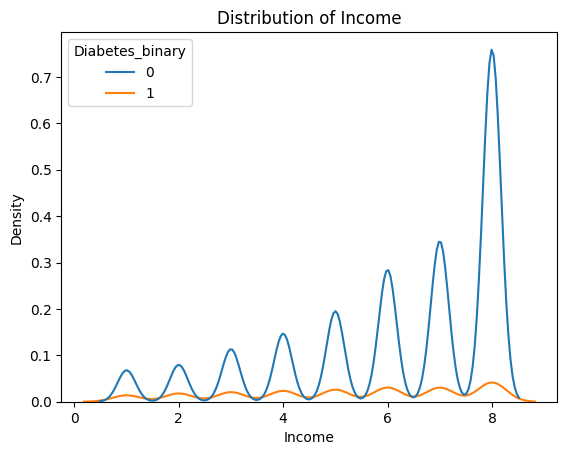

In [ ]:
feature_cols = df_numeric.columns
#update the df with the dependent var column
df_numeric["Diabetes_binary"] = y

for col in feature_cols:
    sns.kdeplot(data=df_numeric, x= col, hue='Diabetes_binary')
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=0)
    plt.show()

**The distribution of general health: diabetes peaks at 3, 'good', vs a higher peak at 'very good' for non-diabetes; the proportion of the area of diabetes to non-diabetes is higher in the 'fair' and 'poor' rankings.**

**The distribution of mental health is hard to interpret due to the class imbalance. However, physical health 'number of days not good' seems to have an increased report in diabetes.**

**Density function is not the best graph to visualize age (especially non-normalized/scaled), but the shape of the distribution is different for diabetes as expected, with frequency increasing with age.**


**Now we will look at how features may be correlated**

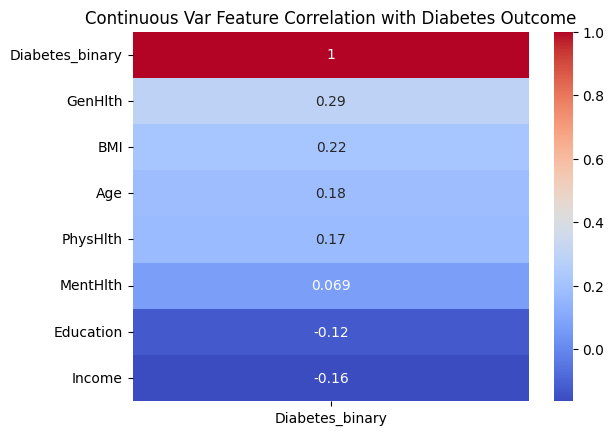

In [19]:
cor = df_numeric.corr(numeric_only=True)
sns.heatmap(cor[["Diabetes_binary"]].sort_values(by="Diabetes_binary", ascending=False), annot=True, cmap='coolwarm')
plt.title('Continuous Var Feature Correlation with Diabetes Outcome')
plt.show()

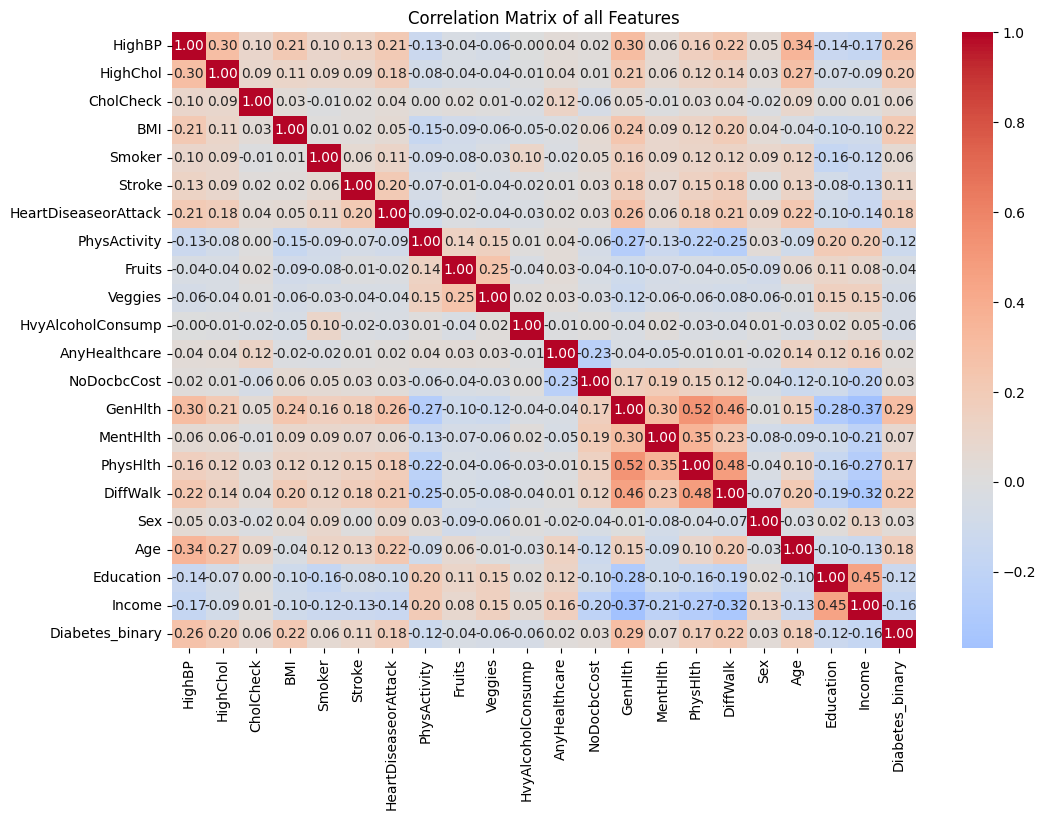

In [20]:
cor2 = df.corr(numeric_only=True)

plt.figure(figsize=(12, 8))
sns.heatmap(cor2, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Correlation Matrix of all Features')
plt.show()

**General health, BMI, age, and physical health (in this order) have the highest correlations with diabetes outcome, which make sense from our knowledge of this disease, and from the observations of the density plots. High blood pressure and high cholesterol (full correlation heat map) were highly correlated with each other, and with diabetes as expected. Mental health has very little correlation which is also in line with observations in the density plot, income and education are inversely correlated with the outcome, with income having the greatest inverse correlation of the two. This would be an interesting point to explore as it could indicate access to health care or other factors where interventions could improve outcomes.**

 **High cholesterol, high blood pressure, age, diabetes, general health are all highly correlated with each other. Difficulty walking, general health, and physical health are highly correlated as would be expected. Fruits and veggies were correlated with each other, but not with other features in the dataset.**

 **Mental health had very little correlation, while education was inversely correlated with the outcome. This would be an interesting point to explore as it could indicate access to health care or other factors where interventions could improve outcomes.**



**Calculate Variance Inflation Factor (VIF) to check for multicollinearity**

**VIF is a measure of how much the variance of an estimated regression coefficient increases when your predictors are correlated. A VIF above 10 is often considered indicative of multicollinearity.**

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Exclude the target variable
X_vif = df_numeric.drop(columns=['Diabetes_binary'], errors='ignore')

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
print(vif_data)

     feature        VIF
0        BMI  15.573038
1    GenHlth   9.454578
2   MentHlth   1.426430
3   PhysHlth   1.809370
4        Age   7.274890
5  Education  22.621672
6     Income  12.544472


**Education - Income: both have high VIF values and their correlation is 0.45 — high enough to inflate VIF, especially if both are also correlated with Age and GenHlth.**

**General health (GenHlth) has moderate correlation with Mental health (MentHlth) (0.30), Physical health (PhysHlth) (0.52), and Difficulty walking (DiffWalk) (0.46) — which explains its borderline VIF.**

**BMI doesn't show a single very strong correlation (>0.7) but has many small-to-moderate correlations, which can still cause high VIF (collinearity can be “spread out” across multiple features).**

**This is more of an issue for regression, but even with neural network modeling colinearity can slow training, increase overfitting risk, and make feature importance less interpretable. We may want to consider eliminating some features or combining features like Education and Income into a socioeconomic index. However, no pairwise features have greater than 80% correlation so we may want to proceed with a first model with the existing features.**

## **Summary of Week One:**

**Class imbalance exists and needs to be handled. There is a mix of continuous, ordinal, and binary features that may need to be handled differently. There may be features in the dataset that should be removed due to colinearity.  I did not find any features with 80% or greater correlation.  I calcuated VIF for the features in the dataset, and while age, education, and BMI all had values > 10, I don't think this indicates that these should be removed.**

**Data Limitations & Potential Biases to address in this data set:**
**The source of this data is from the CDC Behavioral Risk Factor Surveillance System (BRFSS), which is a telephone survey. There is a potential for the following reporting biases:**

- Social Desirability. Respondents may under-report behaviors with negative perception while over-reporting those associated with positive traits.
- Recall. May be difficult to accurately remember the number of days a health condition has occurred unless a diary is kept.
- Subjective Interpretation. Ratings of "good health" may vary among respondents.
- Selection. Participants in telephone surveys may differ in lifestyle or availability from those who do not choose to participate.

**It should also be noted that telephone surveys may provide a benefit over participant-completed forms:**
- Higher completion rates
- Greater accessibility to participants who do not like or want to bother with technology.
- Potential for clarification of responses.

**Particular attention will be paid to these type of features when we analyze the output from various models such as SHAP explainability.**

**We may want to consider how representative these findings are to the general US population as the proportion of extremely obese subjects in this dataset is less than what is reported by the US Census Bureau.**




** **

## **WEEK TWO: Feature Engineering & Deep Learning Prep**
- Encode high-cardinality categorical features with integer labels for embedding layers
- Normalize numerical features where needed
- Split data into train/val/test with stratification
- Convert datasets into PyTorch Dataloaders or TensorFlow tf.data objects

**TASKS:**
- drop duplicate rows
- handle class imbalance
- deal with outliers and skewed distribution
- feature scaling

**Drop duplicate rows**

In [35]:
df_clean = df.copy()
df_clean= df_clean.drop_duplicates() 
print(f"Number of rows after removing duplicates: {df_clean.shape[0]}")


Number of rows after removing duplicates: 229474


**Transform non-binary features and check the distribution after scaling**

In [ ]:
from sklearn.preprocessing import PowerTransformer, RobustScaler
# Feature transformations: Select continuous and ordinal columns (excluding binary and target)
continuous_cols = ['BMI', 'Age', 'Education', 'Income']

X_continuous = df_clean[continuous_cols]

# Robust scaling to reduce outlier impact
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_continuous)

# Replace original columns with transformed values in your dataframe
df_clean[continuous_cols] = X_scaled

# Now df_clean has transformed features ready for modeling

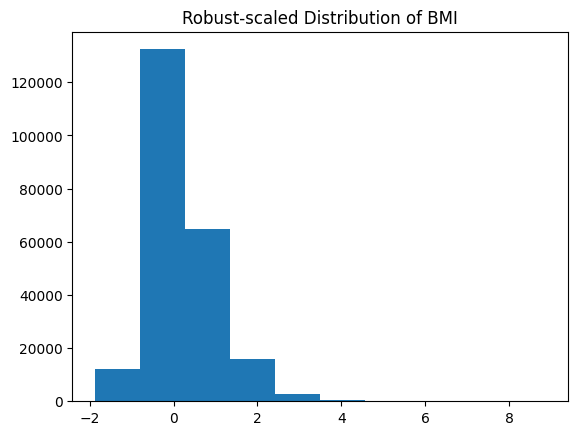

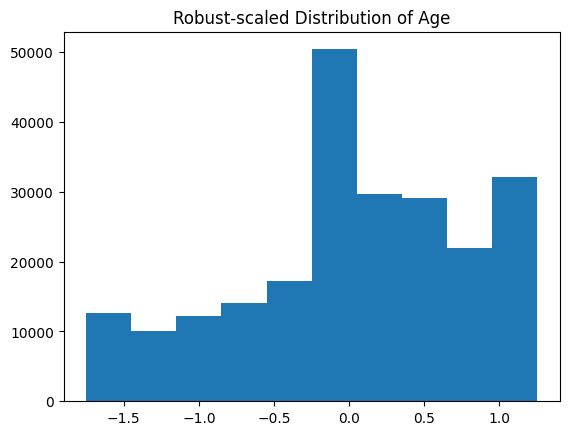

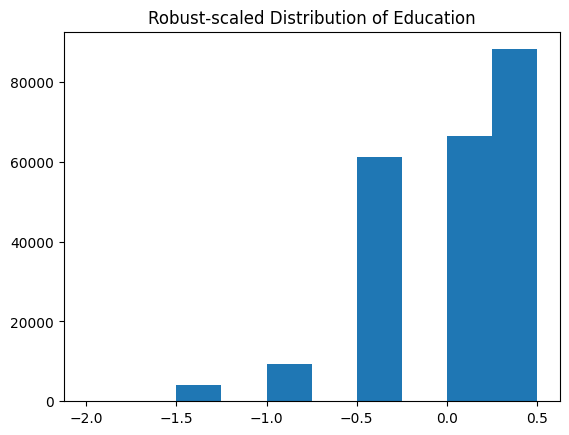

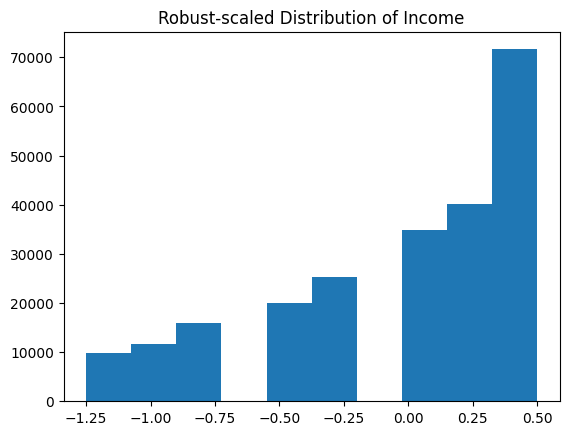

In [41]:
for col in continuous_cols:
    plt.hist(data=df_clean, x= col)
    plt.title(f'Robust-scaled Distribution of {col}')
    plt.xticks(rotation=0)
    plt.show()

**Create an updated X/y dataset without duplicates to do the train/test split**

In [ ]:
X = df.drop(columns=['Diabetes_binary'], errors='ignore')
y = df['Diabetes_binary']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


**Now we can address class imbalance - first we try with SMOTE**

In [ ]:
from imblearn.over_sampling import SMOTE    
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)



**Now we can prepare training sets for pytorch models**

In [43]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Convert to torch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Now train_loader and test_loader are ready for PyTorch models